### Twitter Hate Speech Classification
Referance : [kraggle](https://www.kaggle.com/code/prakharprasad/twitter-hate-speech-classification)

Issue i gues is bad data 

> Using NLP and ML to make a model to identify racist or sexist tweets in twitter

Clean up tweets and build a classification model by using NLP techniques, cleanup specific for tweets data, regularization and hyperparameter tuning using stratified k-fold and cross validation to get the best model.

In [248]:
# packages for data manipulation
import os
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# consistent sized plot
from pylab import rcParams
rcParams['figure.figsize'] = 12, 5
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12

# handle the warnings in the code
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re

pd.options.display.max_columns = None

<Axes: xlabel='label', ylabel='count'>

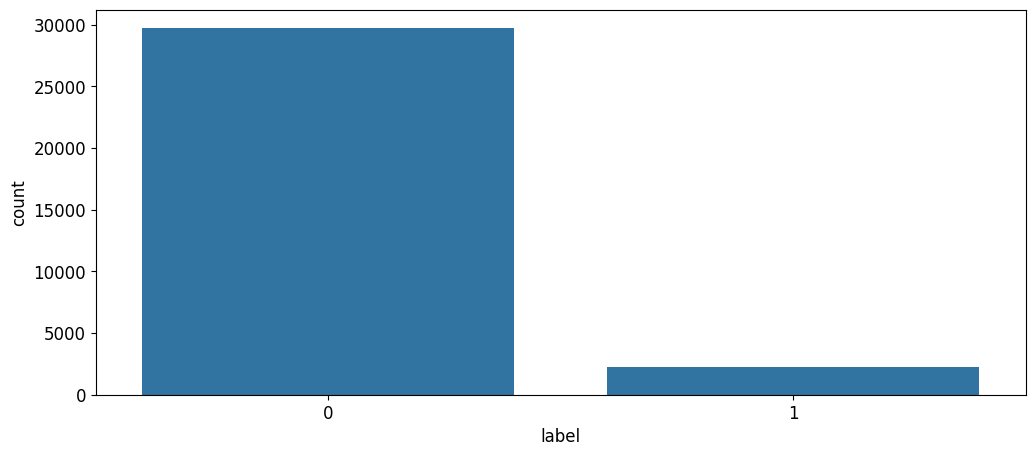

In [249]:
# loading the csv file as a pandas data frame
# ISO-8859-1
import seaborn as sns
tweet = pd.read_csv('TwitterHate.csv', encoding='utf-8-sig', delimiter=',', engine='python')
sns.countplot(data=tweet, x='label')

In [250]:
tweet.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [251]:
# get rid of the identifier number of the tweets
tweet.drop('id', axis=1, inplace=True)

In [252]:
# view one of the tweets randomly
random = np.random.randint(0, len(tweet))
print(random)
tweet.iloc[random]['tweet']

3588


'instead of being   with somone, why not try to figure out what they are here to teach you...they always teach us something!'

In [253]:
# create a copy of the original data
df = tweet.copy()

### Text Cleaning

Handle diacritics using text normalization

In [254]:
def simplify(text):
    # function to handle the diacritics in text
    import unicodedata
    try:
        text = unicode(text, 'utf-8')
    except NameError:
        pass
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode('utf-8')
    return str(text)

In [255]:
# damn i didnt know this was a function xD
df['tweet'] = df['tweet'].apply(simplify)

Remove user handles

In [256]:
df['tweet'].replace(r'@\w+', '', regex=True, inplace=True)

Remove url

In [257]:
# trying regex on a sample string
text = "Visit http://example.com and https://example.org for more information. Follow me on Twitter: @user123."
url_pattern = re.compile(r'https?://\S+|www\.\S+')
result = url_pattern.sub('', text)
print(result)

Visit  and  for more information. Follow me on Twitter: @user123.


In [258]:
df['tweet'].replace(r'https?://\S+|www.\.\S+', '', regex=True, inplace=True)

Tokenize tweets using tweet tokenizer

In [259]:
# sample
sample = "wonderfl :-)  when are you coming for #party"
tweet_tokenize = TweetTokenizer(preserve_case=True)
tweet_tokenize.tokenize(sample)

['wonderfl', ':-)', 'when', 'are', 'you', 'coming', 'for', '#party']

In [260]:
#tokenize the tweets in the dataframe using TweetTokenizer
tokenizer = TweetTokenizer(preserve_case=True)
df['tweet'] = df['tweet'].apply(tokenizer.tokenize)

In [261]:
# view tokenized tweets
df.head(3)

,label,tweet
0,0,"[when, a, father, is, dysfunctional, and, is, ..."
1,0,"[thanks, for, #lyft, credit, i, can't, use, ca..."
2,0,"[bihday, your, majesty]"


Remove the stop words!

In [262]:
stop_words = stopwords.words('english')
additional_lst = ['amp', 'rt', 'u', "can't", 'ur']
stop_words.extend(additional_lst)

In [263]:
stop_words[-10:]

["weren't",
 'won',
 "won't",
 'wouldn',
 "wouldn't",
 'amp',
 'rt',
 'u',
 "can't",
 'ur']

In [264]:
# function to remove stop words
def remove_stopwords(text):
    cleaned = [word for word in text if word not in stop_words]
    return cleaned

In [265]:
# removing stop words from the tweets
df['tweet'] = df['tweet'].apply(remove_stopwords)

In [266]:
df['tweet'].head()

0    [father, dysfunctional, selfish, drags, kids, ...
1    [thanks, #lyft, credit, use, cause, offer, whe...
2                                    [bihday, majesty]
3                  [#model, love, take, time, !, !, !]
4                [factsguide, :, society, #motivation]
Name: tweet, dtype: object

Spelling correction with textblob

In [267]:
from textblob import TextBlob
sample = 'amazng man you did it finally'
txtblob = TextBlob(sample)
corrected = txtblob.correct()
corrected

TextBlob("amazing man you did it finally")

In [268]:
from textblob import TextBlob
# a string is passed and not a list of strings
def spell_check(text):
    text = ' '.join(text)
    corrected = TextBlob(text).correct()
    return str(corrected)

spell_check(['bihday', 'majesty'])
# df['tweet'] = df['tweet'].apply(spell_check)

'midday majesty'

In [269]:
# removing # symbol used in hastags
# here is a sample
sample = "#winner #machine i am learning"
re.sub(re.compile('#'),'' ,sample)

'winner machine i am learning'

In [270]:
def remove_hashsymbol(text):
    pattern = (r'#')
    text = ' '.join(text)
    clean_text = re.sub(pattern, '', text)
    return tokenizer.tokenize(clean_text)

df['tweet'] = df['tweet'].apply(remove_hashsymbol)

Remove single and double length characters

In [271]:
def rem_shorwords(text):
    # remove words of length 1 and 2
    lengths = [1, 2]
    new_text = ' '.join(text)
    for word in text:
        text = [word for word in tokenizer.tokenize(new_text) if not len(word) in lengths]
    return new_text

In [272]:
df['tweet'] = df['tweet'].apply(rem_shorwords)

In [273]:
df.head(2)

,label,tweet
0,0,father dysfunctional selfish drags kids dysfun...
1,0,thanks lyft credit use cause offer wheelchair ...


In [274]:
df['tweet'] = df['tweet'].apply(tokenizer.tokenize)
df.head(3)

,label,tweet
0,0,"[father, dysfunctional, selfish, drags, kids, ..."
1,0,"[thanks, lyft, credit, use, cause, offer, whee..."
2,0,"[bihday, majesty]"


Remove digits

In [275]:
def rem_digits(text):
    no_digits = []
    for word in text:
        no_digits.append(re.sub(r'\d', '', word))
    return ' '.join(no_digits)

In [276]:
df['tweet'] = df['tweet'].apply(rem_digits)

In [277]:
df['tweet'] = df['tweet'].apply(tokenizer.tokenize)

In [278]:
df.head()

,label,tweet
0,0,"[father, dysfunctional, selfish, drags, kids, ..."
1,0,"[thanks, lyft, credit, use, cause, offer, whee..."
2,0,"[bihday, majesty]"
3,0,"[model, love, take, time, !, !, !]"
4,0,"[factsguide, :, society, motivation]"


Remove Special Characters

In [279]:
def rem_noalpha(text):
    text = [word for word in text if word.isalpha()]
    return text

In [280]:
df['tweet'] = df['tweet'].apply(rem_noalpha)

In [281]:
df.head()

,label,tweet
0,0,"[father, dysfunctional, selfish, drags, kids, ..."
1,0,"[thanks, lyft, credit, use, cause, offer, whee..."
2,0,"[bihday, majesty]"
3,0,"[model, love, take, time]"
4,0,"[factsguide, society, motivation]"


In [282]:
# df['tweet'] = df['tweet'].select(spell_check)

Data analysis

In [283]:
# sns.countplot(df['label'])
# plt.title('Count of Hate vs Non Hate Tweet')
# plt.grid()
# plt.show()

In [284]:
from collections import Counter
results = Counter()
df['tweet'].apply(results.update)
#print the top 10 most common terms in the tweet 
print(results.most_common(10))

[('love', 2762), ('day', 2319), ('happy', 1679), ('like', 1160), ('time', 1138), ('life', 1124), ('today', 1017), ('new', 994), ('thankful', 947), ('positive', 931)]


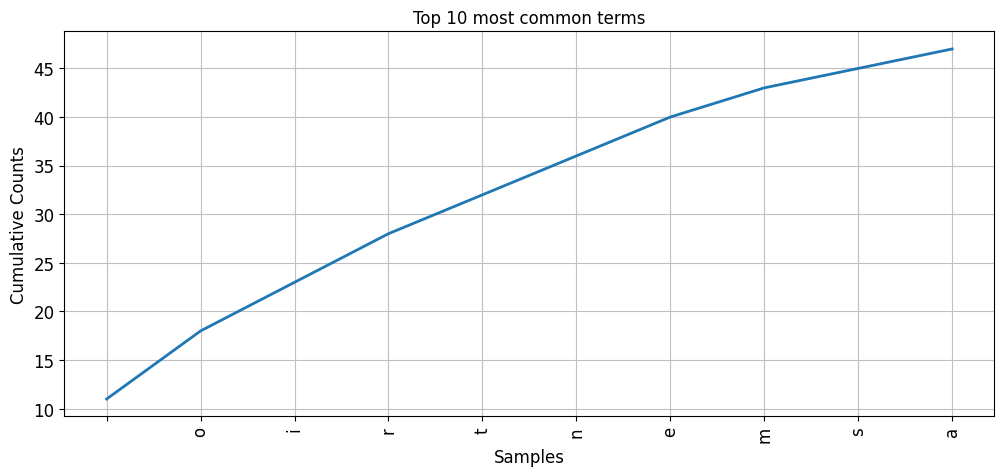

In [285]:
frequency = nltk.FreqDist(result)
plt.title('Top 10 most common terms')
frequency.plot(10, cumulative=True)
plt.show()

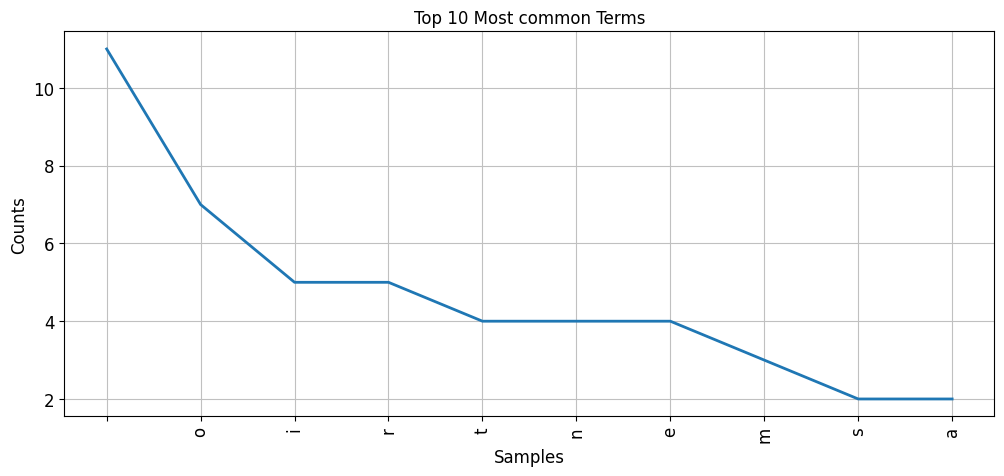

In [286]:
frequency = nltk.FreqDist(result)
plt.title('Top 10 Most common Terms')
frequency.plot(10, cumulative=False)
plt.show()

In [287]:
df.head()

,label,tweet
0,0,"[father, dysfunctional, selfish, drags, kids, ..."
1,0,"[thanks, lyft, credit, use, cause, offer, whee..."
2,0,"[bihday, majesty]"
3,0,"[model, love, take, time]"
4,0,"[factsguide, society, motivation]"


In [288]:
df.isnull().sum()

label    0
tweet    0
dtype: int64

In [289]:
df.head()
DF = pd.DataFrame(df)

In [290]:
def join_lst(x):
    return ' '.join(x)

# df['tweet'] = df['tweet'].apply(join_lst)

In [291]:
df['tweet'] = DF['tweet'].apply(join_lst)
df.head()

,label,tweet
0,0,father dysfunctional selfish drags kids dysfun...
1,0,thanks lyft credit use cause offer wheelchair ...
2,0,bihday majesty
3,0,model love take time
4,0,factsguide society motivation


Training

In [292]:
X = df['tweet']
y = df['label']

In [293]:
from sklearn.model_selection import train_test_split
seed = 51
test_size = 0.2
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=seed,stratify=df['label'])
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
print(X_train)

(25569,) (6393,) (25569,) (6393,)
2732        kicks today check full list guests see weekend
9850     looking forward another great day tomorrow w t...
25413    wedding planning got like engaged somuch stressed
1527       thankful honest conversations thankful positive
1700     billy goat trail outdoor education flashbacks ...
                               ...                        
11264    funny tragically close truth folk continue per...
3040                            thankful thankful positive
23138    happy th bihday shane robe watson bihday shane...
6862     first views new shis done well youtube youtube...
27374                      thankful love thankful positive
Name: tweet, Length: 25569, dtype: object


In [294]:
print(X)

0        father dysfunctional selfish drags kids dysfun...
1        thanks lyft credit use cause offer wheelchair ...
2                                           bihday majesty
3                                     model love take time
4                            factsguide society motivation
                               ...                        
31957                                     ate isz youuu ai
31958    see nina turner airwaves trying wrap mantle ge...
31959      listening sad songs monday morning otw work sad
31960      sikh temple vandalised calgary wso condemns act
31961                                         thank follow
Name: tweet, Length: 31962, dtype: object


In [295]:
# use tf-idf as feature to get vector space model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [296]:
vectorize = TfidfVectorizer(max_features=5000)

In [297]:
# piekel the value of X_train into a file
import pickle
pickle.dump(X_train, open('../../X_train.pkl', 'wb'))

In [298]:
# fit on the training data
X_train = vectorize.fit_transform(X_train)
# transform the test data
X_test = vectorize.transform(X_test)

In [299]:
print(X_test)

  (0, 4531)	0.40411733208269035
  (0, 3748)	0.6026792301042109
  (0, 1857)	0.3553259401046642
  (0, 120)	0.5892456226397449
  (1, 3903)	0.2940167949572804
  (1, 3547)	0.42888448659870554
  (1, 2937)	0.26163637474232637
  (1, 2148)	0.3745027725707167
  (1, 1857)	0.23029552208788867
  (1, 1437)	0.39457344516823306
  (1, 1365)	0.3745027725707167
  (1, 1073)	0.41464411776574944
  (2, 3830)	0.3384316550940158
  (2, 3794)	0.35343742564877667
  (2, 3310)	0.30994857636443374
  (2, 2891)	0.4101092371962912
  (2, 2664)	0.40172644191229456
  (2, 1498)	0.38140182095921876
  (2, 770)	0.4352433932807109
  (3, 4773)	0.42722670754258235
  (3, 3953)	0.600192567511336
  (3, 1903)	0.3519888362439583
  (3, 521)	0.577364773281241
  (4, 4630)	0.5944015397327808
  (4, 4604)	0.6415749257491391
  :	:
  (6389, 3456)	0.3107550270743735
  (6390, 3598)	0.3205879144284205
  (6390, 3223)	0.2253138980833031
  (6390, 3070)	0.24576638689129635
  (6390, 2529)	0.3038109929349172
  (6390, 1770)	0.2703594416676663
  (6390,

In [300]:
# import the model
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [301]:
# instantiate the model with default hyper parameters
clf = LogisticRegression()
clf.fit(X_train, y_train)
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

Model evaluation

In [302]:
# import the metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [303]:
print('Accuracy Score on training set %.5f' %accuracy_score(y_train, train_predictions))
print('Accuracy Score on the test set %.5f' %accuracy_score(y_test, test_predictions))

Accuracy Score on training set 0.95569
Accuracy Score on the test set 0.94791


This is not a good metric for an imblanced data set case. This can be highlited using f1 score. A low f1 score for a lable indicates poor performace of the model

In [304]:
print('Classification Report Training Set')
print('\n')
print(classification_report(y_train, train_predictions))

Classification Report Training Set


              precision    recall  f1-score   support

           0       0.96      1.00      0.98     23775
           1       0.95      0.39      0.55      1794

    accuracy                           0.96     25569
   macro avg       0.95      0.69      0.76     25569
weighted avg       0.96      0.96      0.95     25569



In [305]:
print('Classification Report Testing Set')
print('\n')
print(classification_report(y_test, test_predictions))

Classification Report Testing Set


              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5945
           1       0.90      0.29      0.44       448

    accuracy                           0.95      6393
   macro avg       0.93      0.64      0.70      6393
weighted avg       0.95      0.95      0.94      6393



The model's f1-score is low for label 1 which indicates the hate text in twitter

Weighted Logistic Regression or Cost Sensitive Logistic Regression

In [306]:
df['label'].value_counts()

label
0    29720
1     2242
Name: count, dtype: int64

In [307]:
#define the weight of the class labels using inverse ratio
weights = {0:1.0,1:13.0}

#instantiate the logistic regression model and account for the weights to be applied for model coefficients update magnitude
clf = LogisticRegression(solver='lbfgs',class_weight=weights)

#fit and predict
clf.fit(X_train,y_train)
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

#classification report
print('Classification Report Training set')
print('------------------------------------')
print('\n')
print(classification_report(y_train,train_predictions))
print('\n')

print('Classification Report Testing set')
print('------------------------------------')
print('\n')
print(classification_report(y_test,test_predictions))

Classification Report Training set
------------------------------------


              precision    recall  f1-score   support

           0       1.00      0.95      0.97     23775
           1       0.60      0.98      0.74      1794

    accuracy                           0.95     25569
   macro avg       0.80      0.96      0.86     25569
weighted avg       0.97      0.95      0.96     25569



Classification Report Testing set
------------------------------------


              precision    recall  f1-score   support

           0       0.98      0.94      0.96      5945
           1       0.48      0.75      0.58       448

    accuracy                           0.92      6393
   macro avg       0.73      0.84      0.77      6393
weighted avg       0.94      0.92      0.93      6393



The f1 score of both the training and testing set has imporved compared to the plain vanilla Logistic Regression model. There is still more oppourtunity to imporve the score using better models or handling the data imbalance by adding synthetic data

Regularization and Hyperparameter tuning

In [308]:
#import the required libraries for grid search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [309]:
# define search space
from scipy.stats import loguniform
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)

In [310]:
# check the space search
print(space)

{'solver': ['newton-cg', 'lbfgs', 'liblinear'], 'penalty': ['l1', 'l2', 'elasticnet'], 'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x293113e90>}


Fine tuned model based on balanced class weights

In [311]:
#define the model with balanced class weights
weights = {0:1.0,1:1.0}
clf = LogisticRegression(class_weight=weights)
#define the number of folds 
folds = StratifiedKFold(n_splits=4,random_state=seed, shuffle=True)
# define search
grid_search = RandomizedSearchCV(estimator=clf,param_distributions=space, n_iter=100, scoring='recall',
                            n_jobs=-1, cv=folds, random_state=seed)
#fit grid search on the train data
grid_result = grid_search.fit(X_train,y_train)

/Users/adityahegde/Projects/pleasebekind/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
248 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
52 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/adityahegde/Projects/pleasebekind/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/adityahegde/Projects/pleasebekind/venv/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/aditya

In [312]:
#retrieve the best model 
grid_result.best_estimator_

LogisticRegression(C=23.8719267543995, class_weight={0: 1.0, 1: 1.0},
                   penalty='l1', solver='liblinear')

In [313]:
clf = LogisticRegression(C=23.871926754399514,penalty='l1',solver='liblinear',class_weight=weights)

In [314]:
# fit and predict
clf.fit(X_train, y_train)
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

#classification report
print('Classification Report Training set')
print(classification_report(y_train,train_predictions))
print('\n')

print('Classification Report Testing set')
print(classification_report(y_test,test_predictions))

Classification Report Training set
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23775
           1       0.98      0.93      0.95      1794

    accuracy                           0.99     25569
   macro avg       0.99      0.96      0.97     25569
weighted avg       0.99      0.99      0.99     25569



Classification Report Testing set
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5945
           1       0.62      0.56      0.59       448

    accuracy                           0.94      6393
   macro avg       0.79      0.77      0.78      6393
weighted avg       0.94      0.94      0.94      6393



Fine tuned model with calss weights proprtional to the calss imbalance

In [315]:
#use the class weights to handle the imbalance in the labels
weights = {0:1.0,1:13}

clf = LogisticRegression(class_weight=weights)
#define the number of folds 
folds = StratifiedKFold(n_splits=4,random_state=seed, shuffle=True)
# define search
grid_search = RandomizedSearchCV(estimator=clf,param_distributions=space, n_iter=100, scoring='recall',
                            n_jobs=-1, cv=folds, random_state=seed)
#fit grid search on the train data
grid_result = grid_search.fit(X_train,y_train)

#retrieve the best model 
grid_result.best_estimator_

/Users/adityahegde/Projects/pleasebekind/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adityahegde/Projects/pleasebekind/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

LogisticRegression(C=0.16731783677034173, class_weight={0: 1.0, 1: 13},
                   solver='liblinear')

In [316]:
#instantiate the best model
from sklearn.neural_network import MLPClassifier
clf = LogisticRegression(C=0.16731783677034165,penalty='l2',solver='liblinear',class_weight=weights)
clf2 = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
#fit and predict
clf.fit(X_train,y_train)
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

#classification report
print('Classification Report Training set')
print('------------------------------------')
print('\n')
print(classification_report(y_train,train_predictions))
print('\n')

print('Classification Report Testing set')
print('------------------------------------')
print('\n')
print(classification_report(y_test,test_predictions))

Classification Report Training set
------------------------------------


              precision    recall  f1-score   support

           0       0.99      0.94      0.97     23775
           1       0.53      0.93      0.68      1794

    accuracy                           0.94     25569
   macro avg       0.76      0.93      0.82     25569
weighted avg       0.96      0.94      0.95     25569



Classification Report Testing set
------------------------------------


              precision    recall  f1-score   support

           0       0.98      0.93      0.96      5945
           1       0.46      0.77      0.58       448

    accuracy                           0.92      6393
   macro avg       0.72      0.85      0.77      6393
weighted avg       0.95      0.92      0.93      6393



In [317]:
clf2.fit(X_train, y_train)

/Users/adityahegde/Projects/pleasebekind/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

In [318]:
train_predictions2 = clf2.predict(X_train)
test_predictions2 = clf2.predict(X_test)

In [319]:
print(classification_report(y_train, train_predictions2))
print(classification_report(y_test, test_predictions2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23775
           1       0.97      0.96      0.97      1794

    accuracy                           1.00     25569
   macro avg       0.99      0.98      0.98     25569
weighted avg       1.00      1.00      1.00     25569

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5945
           1       0.61      0.60      0.60       448

    accuracy                           0.95      6393
   macro avg       0.79      0.78      0.79      6393
weighted avg       0.94      0.95      0.94      6393



In [335]:
# save the clf2 model

In [334]:
clf2.predict(X_test[1])

array([0])

In [321]:
X_test[1]

<1x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

Confusion Matrix:


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Prediction', ylabel='Test'>

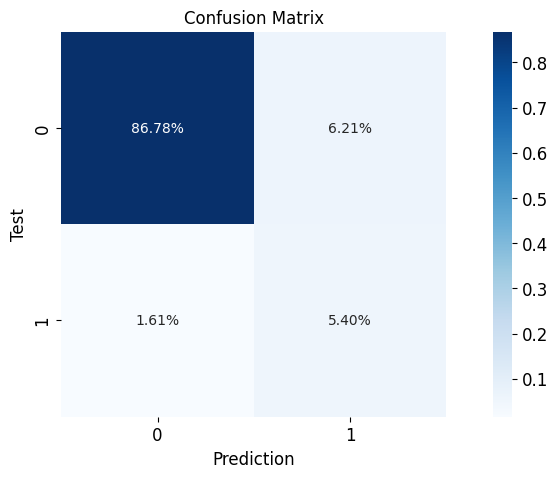

In [322]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns

# calculate the confusion matrix
y_pred = clf.predict(X_test)

# display the confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
labels = ["True Neg","False Pos","False Neg","True Pos"]
# add the lables to the sns.heatmap
s = sns.heatmap(cm/np.sum(cm), annot=True, cmap='Blues', fmt='.2%', square=True)
s.set(xlabel='Prediction', ylabel='Test', title='Confusion Matrix')
s

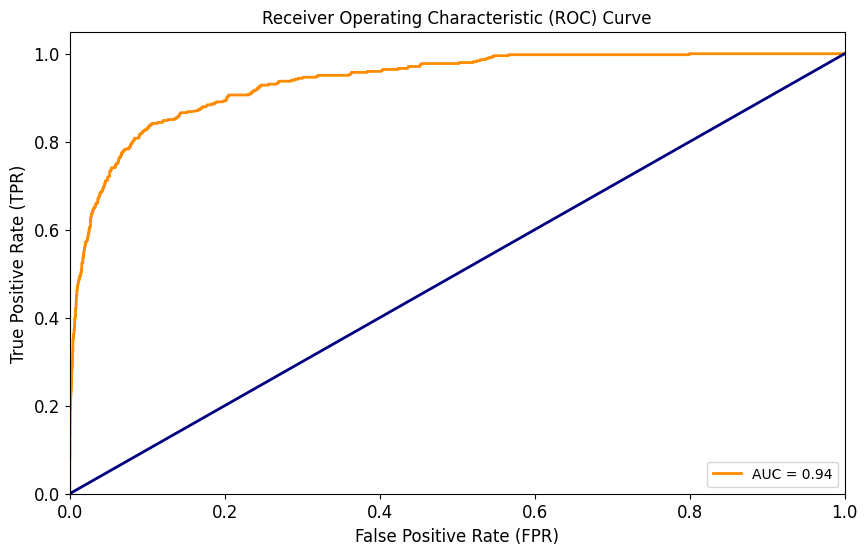

In [323]:
from sklearn.metrics import roc_curve, auc

y_prob = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0, 1], color='navy', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [324]:
import pickle

with open('../../test1.pkl', 'wb') as pf:
    pickle.dump(clf, pf)

clf.coef_

array([[ 0.70902737, -0.80593376, -0.24310772, ...,  0.17690548,
        -0.17199044, -0.14597454]])

In [325]:
with open('../../test1.pkl', 'rb') as pf:
    modelLoaded = pickle.load(pf)

In [326]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# model = Word2Vec.load("word2vec.model")

# model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
# model.save("word2vec.model")

# path_to_word2vec = 'word2vec.model'
# word2vec_model = KeyedVectors.load_word2vec_format(path_to_word2vec)
# word_vector = word2vec_model['test']
# word_vector

# print(word_vector)


# count_vect = CountVectorizer()
# tfidf_transformer = TfidfTransformer
# text = "The movie was amazing"
# vectorized = tfidf_transformer.transform(count_vect.transform([text]))
# predictions = clf.predict(vectorize.reshape(-1, 1))


In [327]:
from sklearn.feature_extraction.text import CountVectorizer
sents = ['coronavirus is a highly infectious disease',
   'coronavirus affects older people the most',
   'older people are at high risk due to this disease']

cv = CountVectorizer()
X = cv.fit_transform(sents)
X = X.toarray()
X

array([[0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0],
       [0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1]])

In [328]:
sorted(cv.vocabulary_.keys())

['affects',
 'are',
 'at',
 'coronavirus',
 'disease',
 'due',
 'high',
 'highly',
 'infectious',
 'is',
 'most',
 'older',
 'people',
 'risk',
 'the',
 'this',
 'to']

In [329]:
cv = CountVectorizer(ngram_range=(2,2))
cv

CountVectorizer(ngram_range=(2, 2))

In [330]:
from sklearn.feature_extraction.text import TfidfVectorizer
sents = ['coronavirus is a highly infectious disease',
   'coronavirus affects older people the most',
   'older people are at high risk due to this disease']

tfidf = TfidfVectorizer()
transformed = tfidf.fit_transform(sents)

import pandas as pd
df = pd.DataFrame(transformed[0].T.todense(),
    	index=tfidf.get_feature_names_out(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
df

,TF-IDF
infectious,0.490479
highly,0.490479
is,0.490479
coronavirus,0.373022
disease,0.373022
older,0.000000
this,0.000000
the,0.000000
risk,0.000000
people,0.000000


In [331]:
from gensim import models

In [332]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

print(common_texts)

[['human', 'interface', 'computer'], ['survey', 'user', 'computer', 'system', 'response', 'time'], ['eps', 'user', 'interface', 'system'], ['system', 'human', 'system', 'eps'], ['user', 'response', 'time'], ['trees'], ['graph', 'trees'], ['graph', 'minors', 'trees'], ['graph', 'minors', 'survey']]


In [333]:
from gensim.models import KeyedVectors
word_vectors = model.wv
word_vectors
word_vectors.save("word2vec.wordvectors")
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')
vector = wv['computer']
vector

array([-0.00515774, -0.00667028, -0.0077791 ,  0.00831315, -0.00198292,
       -0.00685696, -0.0041556 ,  0.00514562, -0.00286997, -0.00375075,
        0.0016219 , -0.0027771 , -0.00158482,  0.0010748 , -0.00297881,
        0.00852176,  0.00391207, -0.00996176,  0.00626142, -0.00675622,
        0.00076966,  0.00440552, -0.00510486, -0.00211128,  0.00809783,
       -0.00424503, -0.00763848,  0.00926061, -0.00215612, -0.00472081,
        0.00857329,  0.00428459,  0.0043261 ,  0.00928722, -0.00845554,
        0.00525685,  0.00203994,  0.0041895 ,  0.00169839,  0.00446543,
        0.0044876 ,  0.0061063 , -0.00320303, -0.00457706, -0.00042664,
        0.00253447, -0.00326412,  0.00605948,  0.00415534,  0.00776685,
        0.00257002,  0.00811905, -0.00138761,  0.00808028,  0.0037181 ,
       -0.00804967, -0.00393476, -0.0024726 ,  0.00489447, -0.00087241,
       -0.00283173,  0.00783599,  0.00932561, -0.0016154 , -0.00516075,
       -0.00470313, -0.00484746, -0.00960562,  0.00137242, -0.00